In [ ]:
import torch
import numpy as np
import torchvision as tv
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def save_checkpoint(save_path, model, optimizer, valid_loss):
  if save_path == None:
    return
  checkpoint = {
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'valid_loss': valid_loss
  }
  torch.save(checkpoint, save_path)
  print(f"Model is saved ==> {save_path}")

def load_checkpoint(load_path, model, optimizer, device):
  if load_path == None:
    return
  checkpoint = torch.load(load_path, map_location = device)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print(f"Load checkpoint from {load_path}")
  return checkpoint['valid_loss']
  

In [ ]:
def save_metrics(save_path, train_loss_list, valid_loss_list):
  if save_path == None:
    return
  metrics = {
      'train_loss_list': train_loss_list,
      'valid_loss_list': valid_loss_list
  }
  torch.save(metrics, save_path)
  print(f"Metrics is saved ==> {save_path}")

def load_metrics(load_path, device):
  if load_path == None:
    return
  metrics = torch.load(load_path, map_location = device)
  return metrics['train_loss_list'], metrics['valid_loss_list']

In [ ]:
def get_resolution(original_resolution):
  area = original_resolution[0] * original_resolution[1]
  return (160, 128) if area < 96*96 else (512, 480)

known_dataset_sizes = {
  'cifar10': (32, 32),
  'cifar100': (32, 32),
  'oxford_iiit_pet': (224, 224),
  'oxford_flowers102': (224, 224),
  'imagenet2012': (224, 224),
}

def get_resolution_from_dataset(dataset):
  if dataset not in known_dataset_sizes:
    return
  return get_resolution(known_dataset_sizes[dataset])

In [ ]:
 precrop, crop = get_resolution_from_dataset('cifar100')

In [ ]:
precrop, crop

(160, 128)

In [ ]:
train_tx = tv.transforms.Compose([
    tv.transforms.Resize((precrop, precrop)),
    tv.transforms.RandomCrop((crop, crop)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
val_tx = tv.transforms.Compose([
    tv.transforms.Resize((crop, crop)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
cd /content/drive/MyDrive/Deep Learning Co Ban

/content/drive/MyDrive/Deep Learning Co Ban


In [ ]:
train_set = tv.datasets.CIFAR100(root = "CIFAR100", transform=train_tx, train=True, download=True)
test_set = tv.datasets.CIFAR100(root = "CIFAR100", transform=val_tx, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(test_set.classes)
print(test_set.class_to_idx)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [ ]:
idx_to_class = {}
for label, index in test_set.class_to_idx.items():
  idx_to_class[index] = label

In [ ]:
print(idx_to_class)

{0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3: 'bear', 4: 'beaver', 5: 'bed', 6: 'bee', 7: 'beetle', 8: 'bicycle', 9: 'bottle', 10: 'bowl', 11: 'boy', 12: 'bridge', 13: 'bus', 14: 'butterfly', 15: 'camel', 16: 'can', 17: 'castle', 18: 'caterpillar', 19: 'cattle', 20: 'chair', 21: 'chimpanzee', 22: 'clock', 23: 'cloud', 24: 'cockroach', 25: 'couch', 26: 'crab', 27: 'crocodile', 28: 'cup', 29: 'dinosaur', 30: 'dolphin', 31: 'elephant', 32: 'flatfish', 33: 'forest', 34: 'fox', 35: 'girl', 36: 'hamster', 37: 'house', 38: 'kangaroo', 39: 'keyboard', 40: 'lamp', 41: 'lawn_mower', 42: 'leopard', 43: 'lion', 44: 'lizard', 45: 'lobster', 46: 'man', 47: 'maple_tree', 48: 'motorcycle', 49: 'mountain', 50: 'mouse', 51: 'mushroom', 52: 'oak_tree', 53: 'orange', 54: 'orchid', 55: 'otter', 56: 'palm_tree', 57: 'pear', 58: 'pickup_truck', 59: 'pine_tree', 60: 'plain', 61: 'plate', 62: 'poppy', 63: 'porcupine', 64: 'possum', 65: 'rabbit', 66: 'raccoon', 67: 'ray', 68: 'road', 69: 'rocket', 70: 'rose', 

In [ ]:
train_set, valid_set = train_test_split(train_set, test_size = 0.2, shuffle = True)

In [ ]:
len(train_set), len(valid_set)

(40000, 10000)

In [ ]:
train_set[0][0].size(), train_set[0][1]

(torch.Size([3, 128, 128]), 36)

In [ ]:
train_dataloader = DataLoader(train_set, batch_size = 64, shuffle = True)
valid_dataloader = DataLoader(valid_set, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_set, batch_size = 1, shuffle = False)


In [ ]:
for batch in train_dataloader:
  image = batch[0]
  label = batch[1]
  print(image.size())
  print(label)
  break

torch.Size([64, 3, 128, 128])
tensor([96, 78, 33, 13, 36, 42, 53, 66, 30, 13, 67, 16, 21, 19, 92, 96, 82, 53,
         7, 83, 16, 30, 88, 21, 32, 66, 40, 19, 38,  8, 44, 26, 22,  6, 20,  3,
        78, 57, 98, 72, 49,  2, 36, 29,  7, 62, 14, 13, 52, 55,  9, 69, 88, 68,
        33, 30, 70, 97, 82, 94, 89, 19, 27, 67])


In [ ]:
class StdConv2d(nn.Conv2d):

  def forward(self, x):
    w = self.weight
    v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
    w = (w - m) / torch.sqrt(v + 1e-10)
    return F.conv2d(x, w, self.bias, self.stride, self.padding,
                    self.dilation, self.groups)


def conv3x3(cin, cout, stride=1, groups=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=3, stride=stride,
                   padding=1, bias=bias, groups=groups)


def conv1x1(cin, cout, stride=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=1, stride=stride,
                   padding=0, bias=bias)


def tf2th(conv_weights):
  """Possibly convert HWIO to OIHW."""
  if conv_weights.ndim == 4:
    conv_weights = conv_weights.transpose([3, 2, 0, 1])
  return torch.from_numpy(conv_weights)


class PreActBottleneck(nn.Module):
  """Pre-activation (v2) bottleneck block.
  Follows the implementation of "Identity Mappings in Deep Residual Networks":
  https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua
  Except it puts the stride on 3x3 conv when available.
  """

  def __init__(self, cin, cout=None, cmid=None, stride=1):
    super().__init__()
    cout = cout or cin
    cmid = cmid or cout//4

    self.gn1 = nn.GroupNorm(32, cin)
    self.conv1 = conv1x1(cin, cmid)
    self.gn2 = nn.GroupNorm(32, cmid)
    self.conv2 = conv3x3(cmid, cmid, stride)  # Original code has it on conv1!!
    self.gn3 = nn.GroupNorm(32, cmid)
    self.conv3 = conv1x1(cmid, cout)
    self.relu = nn.ReLU(inplace=True)

    if (stride != 1 or cin != cout):
      # Projection also with pre-activation according to paper.
      self.downsample = conv1x1(cin, cout, stride)

  def forward(self, x):
    out = self.relu(self.gn1(x))

    # Residual branch
    residual = x
    if hasattr(self, 'downsample'):
      residual = self.downsample(out)

    # Unit's branch
    out = self.conv1(out)
    out = self.conv2(self.relu(self.gn2(out)))
    out = self.conv3(self.relu(self.gn3(out)))

    return out + residual

  def load_from(self, weights, prefix=''):
    convname = 'standardized_conv2d'
    with torch.no_grad():
      self.conv1.weight.copy_(tf2th(weights[f'{prefix}a/{convname}/kernel']))
      self.conv2.weight.copy_(tf2th(weights[f'{prefix}b/{convname}/kernel']))
      self.conv3.weight.copy_(tf2th(weights[f'{prefix}c/{convname}/kernel']))
      self.gn1.weight.copy_(tf2th(weights[f'{prefix}a/group_norm/gamma']))
      self.gn2.weight.copy_(tf2th(weights[f'{prefix}b/group_norm/gamma']))
      self.gn3.weight.copy_(tf2th(weights[f'{prefix}c/group_norm/gamma']))
      self.gn1.bias.copy_(tf2th(weights[f'{prefix}a/group_norm/beta']))
      self.gn2.bias.copy_(tf2th(weights[f'{prefix}b/group_norm/beta']))
      self.gn3.bias.copy_(tf2th(weights[f'{prefix}c/group_norm/beta']))
      if hasattr(self, 'downsample'):
        w = weights[f'{prefix}a/proj/{convname}/kernel']
        self.downsample.weight.copy_(tf2th(w))


class ResNetV2(nn.Module):
  """Implementation of Pre-activation (v2) ResNet mode."""

  def __init__(self, block_units, width_factor, head_size=21843, zero_head=False):
    super().__init__()
    wf = width_factor  # shortcut 'cause we'll use it a lot.

    # The following will be unreadable if we split lines.
    # pylint: disable=line-too-long
    self.root = nn.Sequential(OrderedDict([
        ('conv', StdConv2d(3, 64*wf, kernel_size=7, stride=2, padding=3, bias=False)),
        ('pad', nn.ConstantPad2d(1, 0)),
        ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0)),
        # The following is subtly not the same!
        # ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))

    self.body = nn.Sequential(OrderedDict([
        ('block1', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=64*wf, cout=256*wf, cmid=64*wf))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=256*wf, cout=256*wf, cmid=64*wf)) for i in range(2, block_units[0] + 1)],
        ))),
        ('block2', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=256*wf, cout=512*wf, cmid=128*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=512*wf, cout=512*wf, cmid=128*wf)) for i in range(2, block_units[1] + 1)],
        ))),
        ('block3', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=512*wf, cout=1024*wf, cmid=256*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=1024*wf, cout=1024*wf, cmid=256*wf)) for i in range(2, block_units[2] + 1)],
        ))),
        ('block4', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=1024*wf, cout=2048*wf, cmid=512*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=2048*wf, cout=2048*wf, cmid=512*wf)) for i in range(2, block_units[3] + 1)],
        ))),
    ]))
    # pylint: enable=line-too-long

    self.zero_head = zero_head
    self.head = nn.Sequential(OrderedDict([
        ('gn', nn.GroupNorm(32, 2048*wf)),
        ('relu', nn.ReLU(inplace=True)),
        ('avg', nn.AdaptiveAvgPool2d(output_size=1)),
        ('conv', nn.Conv2d(2048*wf, head_size, kernel_size=1, bias=True)),
    ]))

  def forward(self, x):
    x = self.head(self.body(self.root(x)))
    assert x.shape[-2:] == (1, 1)  # We should have no spatial shape left.
    return x[...,0,0]

  def load_from(self, weights, prefix='resnet/'):
    with torch.no_grad():
      self.root.conv.weight.copy_(tf2th(weights[f'{prefix}root_block/standardized_conv2d/kernel']))  # pylint: disable=line-too-long
      self.head.gn.weight.copy_(tf2th(weights[f'{prefix}group_norm/gamma']))
      self.head.gn.bias.copy_(tf2th(weights[f'{prefix}group_norm/beta']))
      if self.zero_head:
        nn.init.zeros_(self.head.conv.weight)
        nn.init.zeros_(self.head.conv.bias)
      else:
        self.head.conv.weight.copy_(tf2th(weights[f'{prefix}head/conv2d/kernel']))  # pylint: disable=line-too-long
        self.head.conv.bias.copy_(tf2th(weights[f'{prefix}head/conv2d/bias']))

      for bname, block in self.body.named_children():
        for uname, unit in block.named_children():
          unit.load_from(weights, prefix=f'{prefix}{bname}/{uname}/')


KNOWN_MODELS = OrderedDict([
    ('BiT-M-R50x1', lambda *a, **kw: ResNetV2([3, 4, 6, 3], 1, *a, **kw)),
    ('BiT-M-R50x3', lambda *a, **kw: ResNetV2([3, 4, 6, 3], 3, *a, **kw)),
    ('BiT-M-R101x1', lambda *a, **kw: ResNetV2([3, 4, 23, 3], 1, *a, **kw)),
    ('BiT-M-R101x3', lambda *a, **kw: ResNetV2([3, 4, 23, 3], 3, *a, **kw)),
    ('BiT-M-R152x2', lambda *a, **kw: ResNetV2([3, 8, 36, 3], 2, *a, **kw)),
    ('BiT-M-R152x4', lambda *a, **kw: ResNetV2([3, 8, 36, 3], 4, *a, **kw)),
    ('BiT-S-R50x1', lambda *a, **kw: ResNetV2([3, 4, 6, 3], 1, *a, **kw)),
    ('BiT-S-R50x3', lambda *a, **kw: ResNetV2([3, 4, 6, 3], 3, *a, **kw)),
    ('BiT-S-R101x1', lambda *a, **kw: ResNetV2([3, 4, 23, 3], 1, *a, **kw)),
    ('BiT-S-R101x3', lambda *a, **kw: ResNetV2([3, 4, 23, 3], 3, *a, **kw)),
    ('BiT-S-R152x2', lambda *a, **kw: ResNetV2([3, 8, 36, 3], 2, *a, **kw)),
    ('BiT-S-R152x4', lambda *a, **kw: ResNetV2([3, 8, 36, 3], 4, *a, **kw)),
])

In [ ]:
# model = KNOWN_MODELS['BiT-M-R152x2'](head_size = 100, zero_head = True)

In [ ]:
# print(model)

In [ ]:
# for batch in train_dataloader:
#   image = batch[0]
#   label = batch[1]
#   output = model(image)
#   print(output.size())
#   print(output)
#   break

In [ ]:
classes = test_set.classes

In [ ]:
print(classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [ ]:
def predict(model, test_dataloader, device):
  y_pred = []
  y_true = []
  model.eval()
  for batch in test_dataloader:
    image = batch[0].to(device)
    label = batch[1].to(device)
    with torch.no_grad():
      outputs = model(image)
    logits = outputs.detach().cpu().numpy()
    pred_flat = np.argmax(logits, axis=1).flatten()
    y_pred.extend(pred_flat.tolist())

    labels = label.cpu().numpy().flatten()
    y_true.extend(labels.tolist())
    

  print('Classification Report:')
  print(classification_report(y_true, y_pred, target_names = classes))
  return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro')

In [ ]:
def evalution(y_preds, y_true):
    y_preds = y_preds.detach().cpu().numpy()
    y_preds = np.argmax(y_preds, axis=1).flatten()

    y_true = y_true.cpu().numpy().flatten()

    return accuracy_score(y_true, y_preds), f1_score(y_true, y_preds, average='macro')

In [ ]:
def get_schedule(dataset_size):
  if dataset_size < 20_000:
    return [100, 200, 300, 400, 500]
  elif dataset_size < 500_000:
    return [500, 3000, 6000, 9000, 10_000]
  else:
    return [500, 6000, 12_000, 18_000, 20_000]


def get_lr(step, dataset_size, base_lr=0.001):
  """Returns learning-rate for `step` or None at the end."""
  supports = get_schedule(dataset_size)
  # Linear warmup
  if step < supports[0]:
    return base_lr * step / supports[0]
  # End of training
  elif step >= supports[-1]:
    return None
  # Staircase decays by factor of 10
  else:
    for s in supports[1:]:
      if s < step:
        base_lr /= 10
    return base_lr

In [ ]:
def train(model, optimizer, train_dataloader,loss_fn, valid_dataloader, num_epochs, file_path, device):
  train_loss_list = []
  valid_loss_list = []

  best_valid_loss = 99999

  for epoch in range(num_epochs):
    print("====== Epoch: {}/{} =======".format(epoch+1, num_epochs))
    
    total_loss = 0
    train_accuracy = 0
    train_f1 = 0
    nb_train_steps = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
      image = batch[0].to(device)
      label = batch[1].to(device)

      model.zero_grad()

      lr = get_lr(step, len(train_set))
      if lr is None:
        break
      for param_group in optimizer.param_groups:
        param_group["lr"] = lr

      outputs = model(image)

      loss = loss_fn(outputs, label)
      total_loss += loss.item()

      tmp_train_accuracy, tmp_train_f1 = evalution(outputs, label)

      train_accuracy += tmp_train_accuracy
      train_f1 += tmp_train_f1
      nb_train_steps +=1

      loss.backward()
      optimizer.step()

      if step % 100 == 0 or step == len(train_dataloader):
        print("[TRAIN] EPOCH: {} | BATCH: {}/{} | TRAIN_LOSS: {} | TRAIN_ACC: {}".format(epoch+1, step, len(train_dataloader), loss.item(), tmp_train_accuracy))
    
    avg_train_loss = total_loss/len(train_dataloader)
    train_loss_list.append(avg_train_loss)

    print("Train Accuracy: {}".format(train_accuracy/nb_train_steps))
    print("Train F1 Score: {}".format(train_f1/ nb_train_steps))
    print("Train Loss: {}".format(avg_train_loss))

    print("Running Validation....")
    model.eval()

    eval_loss = 0
    eval_accuracy = 0
    eval_f1 = 0
    nb_eval_steps = 0

    for batch in valid_dataloader:
      image = batch[0].to(device)
      label = batch[1].to(device)


      with torch.no_grad():
        outputs = model(image)

        loss = loss_fn(outputs, label)
        eval_loss += loss.item()

        tmp_eval_accuracy, tmp_f1_score = evalution(outputs, label)

        eval_accuracy += tmp_eval_accuracy
        eval_f1 += tmp_f1_score
        nb_eval_steps += 1
    
    avg_eval_loss = eval_loss/nb_eval_steps
    print("Valid loss: {}".format(avg_eval_loss))
    print("Valid Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    print("Valid F1 Score: {}".format(eval_f1 /nb_eval_steps))

    valid_loss_list.append(avg_eval_loss)

    if best_valid_loss > avg_eval_loss:
      best_valid_loss = avg_eval_loss
      save_checkpoint(file_path+'/model.pt', model, optimizer, best_valid_loss)

    save_metrics(file_path + '/metrics.pt',train_loss_list, valid_loss_list)
  print("Fnished Training!")

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [ ]:
!wget https://storage.googleapis.com/bit_models/BiT-M-R152x2.npz

--2021-08-25 17:02:40--  https://storage.googleapis.com/bit_models/BiT-M-R152x2.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 173.194.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1287051752 (1.2G) [application/octet-stream]
Saving to: ‘BiT-M-R152x2.npz.9’

BiT-M-R152x2.npz.9  100%[===================>]   1.20G  52.9MB/s    in 24s     

2021-08-25 17:03:06 (50.6 MB/s) - ‘BiT-M-R152x2.npz.9’ saved [1287051752/1287051752]



In [ ]:
model = KNOWN_MODELS['BiT-M-R152x2'](head_size = 100, zero_head = True)
model.load_from(np.load("/content/drive/MyDrive/Deep Learning Co Ban/BiT-M-R152x2.npz"))

In [ ]:
model = model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train(device = device,model = model, optimizer = optimizer, train_dataloader=train_dataloader, loss_fn = loss_fn, valid_dataloader =valid_dataloader, num_epochs = 40, file_path = r"/content/drive/MyDrive/Deep Learning Co Ban" )

====== Epoch: 1/40 =======


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[TRAIN] EPOCH: 1 | BATCH: 0/625 | TRAIN_LOSS: 4.605169773101807 | TRAIN_ACC: 0.0
[TRAIN] EPOCH: 1 | BATCH: 100/625 | TRAIN_LOSS: 2.0895893573760986 | TRAIN_ACC: 0.6875
[TRAIN] EPOCH: 1 | BATCH: 200/625 | TRAIN_LOSS: 0.6891558766365051 | TRAIN_ACC: 0.84375
[TRAIN] EPOCH: 1 | BATCH: 300/625 | TRAIN_LOSS: 0.5701186060905457 | TRAIN_ACC: 0.84375
[TRAIN] EPOCH: 1 | BATCH: 400/625 | TRAIN_LOSS: 0.665952205657959 | TRAIN_ACC: 0.84375
[TRAIN] EPOCH: 1 | BATCH: 500/625 | TRAIN_LOSS: 1.0660018920898438 | TRAIN_ACC: 0.734375
[TRAIN] EPOCH: 1 | BATCH: 600/625 | TRAIN_LOSS: 0.5027773976325989 | TRAIN_ACC: 0.828125
Train Accuracy: 0.74175
Train F1 Score: 0.6470066172655152
Train Loss: 1.1921204625368118
Running Validation....
Valid loss: 0.610120633984827
Valid Accuracy: 0.8278264331210191
Valid F1 Score: 0.7359953132979694
Model is saved ==> /content/drive/MyDrive/Deep Learning Co Ban/model.pt
Metrics is saved ==> /content/drive/MyDrive/Deep Learning Co Ban/metrics.pt
====== Epoch: 2/40 =======
[TR

In [ ]:
model = KNOWN_MODELS['BiT-M-R152x2'](head_size = 100, zero_head = True)
model.load_from(np.load("/content/drive/MyDrive/Deep Learning Co Ban/BiT-M-R152x2.npz"))
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
load_checkpoint("/content/drive/MyDrive/Deep Learning Co Ban/model.pt", model, optimizer, device)

Load checkpoint from /content/drive/MyDrive/Deep Learning Co Ban/model.pt


0.5082218791877222

In [ ]:
for batch in test_dataloader:
  image = batch[0]
  label = batch[1]
  print(image.size())
  break

torch.Size([1, 3, 128, 128])


In [ ]:
predict(model, test_dataloader, device)

Classification Report:
               precision    recall  f1-score   support

        apple       0.95      0.99      0.97       100
aquarium_fish       0.95      0.96      0.96       100
         baby       0.77      0.81      0.79       100
         bear       0.91      0.81      0.86       100
       beaver       0.79      0.81      0.80       100
          bed       0.92      0.94      0.93       100
          bee       0.91      0.97      0.94       100
       beetle       0.87      0.90      0.88       100
      bicycle       0.92      0.96      0.94       100
       bottle       0.94      0.96      0.95       100
         bowl       0.82      0.82      0.82       100
          boy       0.69      0.81      0.75       100
       bridge       0.94      0.95      0.95       100
          bus       0.90      0.86      0.88       100
    butterfly       0.97      0.96      0.96       100
        camel       0.91      0.90      0.90       100
          can       0.95      0.91      0

(0.8927, 0.8928717786330261)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
train_loss_list, valid_loss_list = load_metrics("/content/drive/MyDrive/Deep Learning Co Ban/metrics.pt", device)

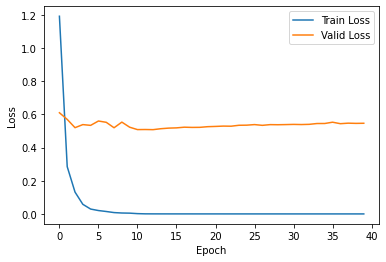

In [ ]:
plt.plot(train_loss_list, label='Train Loss')
plt.plot(valid_loss_list, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
test_set = list(test_set)

In [ ]:
test_set[5]

(tensor([[[ 0.3176,  0.3176,  0.3176,  ..., -0.4902, -0.4980, -0.4980],
          [ 0.3176,  0.3176,  0.3176,  ..., -0.4902, -0.4980, -0.4980],
          [ 0.3098,  0.3098,  0.3098,  ..., -0.4902, -0.4980, -0.4980],
          ...,
          [-0.6471, -0.6471, -0.6549,  ..., -0.5137, -0.5137, -0.5137],
          [-0.7020, -0.7020, -0.7098,  ..., -0.5059, -0.5137, -0.5137],
          [-0.7020, -0.7020, -0.7098,  ..., -0.5059, -0.5137, -0.5137]],
 
         [[ 0.2549,  0.2549,  0.2549,  ..., -0.4275, -0.4353, -0.4353],
          [ 0.2549,  0.2549,  0.2549,  ..., -0.4275, -0.4353, -0.4353],
          [ 0.2471,  0.2471,  0.2471,  ..., -0.4275, -0.4353, -0.4353],
          ...,
          [-0.7176, -0.7176, -0.7333,  ..., -0.6078, -0.6157, -0.6157],
          [-0.7804, -0.7804, -0.7882,  ..., -0.6078, -0.6157, -0.6157],
          [-0.7804, -0.7804, -0.7882,  ..., -0.6078, -0.6157, -0.6157]],
 
         [[-0.1529, -0.1529, -0.1608,  ..., -0.5373, -0.5451, -0.5451],
          [-0.1529, -0.1529,

In [ ]:
image = test_set[5][0].view((1,3,128,128)).to(device)
output = model(image)

In [ ]:
pred = output.detach().cpu().numpy()
pred = np.argmax(pred, axis=1)

In [ ]:
pred, test_set[5][1]

(array([92]), 92)

In [ ]:
print(f"Predict Label: {idx_to_class[pred[0]]}")
print(f"True Label: {idx_to_class[test_set[5][1]]}")

Predict Label: tulip
True Label: tulip


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


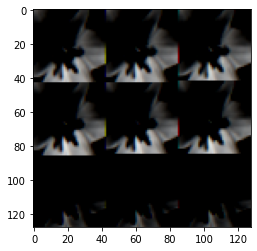

In [ ]:
plt.imshow(test_set[5][0].view(128,128,3))